In [1]:
import torch
import torch.nn as nn
import pytorch_lightning as pl
import random
import numpy as np
import matplotlib.pyplot as plt

from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from einops import rearrange
from tqdm import tqdm

from dataset.utils import process_PVUS

seed = 42
random.seed(seed)
torch.manual_seed(seed)
np.random.seed(seed)
pl.seed_everything(42)

if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

c:\Users\mgphy\Anaconda3\envs\koopman\lib\site-packages\torchaudio\backend\utils.py:74: UserWarning: No audio backend is available.
  warnings.warn("No audio backend is available.")
Seed set to 42


# Load & process dataset

for more datasets:

https://github.com/dtortorella/dyngraphesn/tree/master

In [5]:
config = {
        'reservoir_size': 170,
        'input_scaling': 0.84,
        'reservoir_layers': 6,
        'leaking_rate': 0.17,
        'spectral_radius': 4.85,
        'density': 0.41,
        'reservoir_activation': 'relu',
        'alpha_decay': False
    }

In [3]:
train_dataloader, test_dataloader, val_dataloader = process_PVUS(config, device, ignore_file=False, verbose=True)

# Train the readout

In [3]:
class LinearRegression(pl.LightningModule):
    def __init__(self, input_size, output_size):
        super().__init__()
        self.linear = nn.Linear(input_size, output_size)

    def forward(self, x):
        return self.linear(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        output = self.forward(x)
        loss = nn.MSELoss()(output, y)
        self.log('train_loss', loss)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        output = self.forward(x)
        loss = nn.MSELoss()(output, y)
        self.log('val_loss', loss)

    def test_step(self, batch, batch_idx):
        x, y = batch
        output = self.forward(x)
        loss = nn.MSELoss()(output, y)
        self.log('test_loss', loss)
        
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=0.01)
        return optimizer


In [5]:
forecaster = LinearRegression(input_size=config['reservoir_size'],
                              output_size=1).to(device)

In [6]:
logger = TensorBoardLogger(save_dir="logs", name="dynGESN", version=0)
# %load_ext tensorboard
# %tensorboard --logdir logs

checkpoint_callback = ModelCheckpoint(
    dirpath='logs',
    save_top_k=1,
    monitor='val_loss',
    mode='min',
)
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=0.01, patience=3, verbose=False, mode="min")

trainer = pl.Trainer(
                    # fast_dev_run=True,
                    max_epochs=500,
                    logger=logger,
                    # profiler="simple",
                    # limit_train_batches=0.1, 
                    # limit_val_batches=0.1,
                    devices=1, 
                    accelerator="gpu" if torch.cuda.is_available() else "cpu",
                    # limit_train_batches=50,  # end an epoch after 10 updates
                    # limit_val_batches=50,  # end an epoch after 10 updates
                    callbacks=[checkpoint_callback, early_stop_callback])


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [7]:
trainer.fit(model=forecaster, train_dataloaders=train_dataloader, val_dataloaders=val_dataloader)

You are using a CUDA device ('NVIDIA GeForce RTX 3060') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
c:\Users\mgphy\Anaconda3\envs\koopman\lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:634: Checkpoint directory logs exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name   | Type   | Params
----------------------------------
0 | linear | Linear | 171   
----------------------------------
171       Trainable params
0         Non-trainable params
171       Total params
0.001     Total estimated model params size (MB)


c:\Users\mgphy\Anaconda3\envs\koopman\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
c:\Users\mgphy\Anaconda3\envs\koopman\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Epoch 45: 100%|██████████| 192/192 [00:01<00:00, 127.43it/s, v_num=0]


In [8]:
torch.save(forecaster.state_dict(), "models/dynGESN_readout.pt")

In [6]:
# Specify the path to the saved model
model_path = "models/saved/dynGESN_readout.pt"

# Create an instance of the LinearRegression model
loaded_model = LinearRegression(input_size=config['reservoir_size'], output_size=1).to(device)

# Load the saved model state_dict
loaded_model.load_state_dict(torch.load(model_path))

# Set the model to evaluation mode
loaded_model.eval()

LinearRegression(
  (linear): Linear(in_features=170, out_features=1, bias=True)
)

In [6]:
test_x, test_y = next(iter(test_dataloader))
test_x = test_x[0,:,:].to(device)
test_y = test_y[0,:,:].to(device)

output = loaded_model(test_x)

In [ ]:
# Set the model to evaluation mode
loaded_model = forecaster
loaded_model.to(device).eval()

In [7]:
outputs = []
targets = []

for test_sample in tqdm(test_dataloader):
    test_x, test_y = test_sample[0].to(device), test_sample[1].to(device)
    output = loaded_model(test_x).squeeze()

    outputs.append(output)
    targets.append(test_y)
    if len(outputs) >= 25:
        break

stacked_outputs = torch.stack(outputs, dim=0)
stacked_targets = torch.stack(targets, dim=0).squeeze()

 86%|████████▌ | 24/28 [00:00<00:00, 162.50it/s]


In [14]:
stacked_outputs.shape

torch.Size([25, 32, 200])

In [15]:
stacked_targets.shape

torch.Size([25, 32, 200])

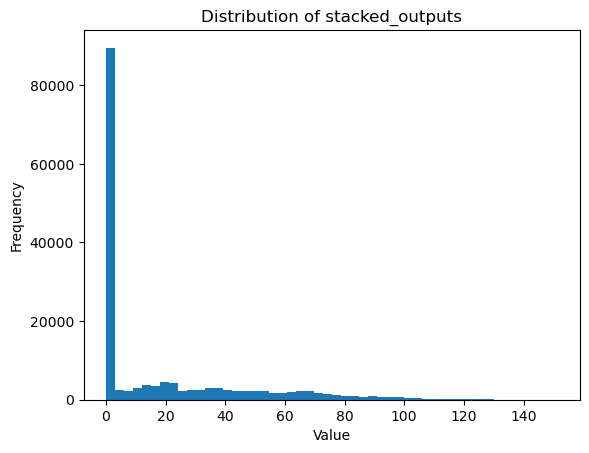

In [8]:
plt.hist(stacked_outputs.flatten().cpu().detach().numpy(), bins=50)
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Distribution of stacked_outputs')
plt.show()

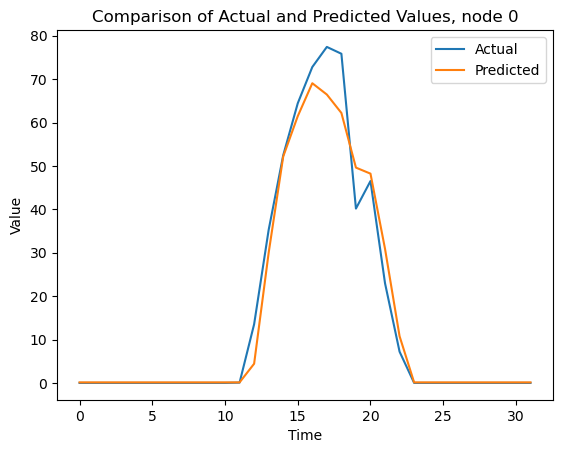

In [9]:
node_id = 0

plt.plot(stacked_targets[0,:,node_id].cpu().detach().numpy(), label='Actual')
plt.plot(stacked_outputs[0,:,node_id].cpu().detach().numpy(), label='Predicted')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Value')
plt.title(f'Comparison of Actual and Predicted Values, node {node_id}')
plt.show()

In [10]:
X = []
Y = []

for test_sample in tqdm(test_dataloader):
    test_x, test_y = test_sample[0][:].to(device), test_sample[1][:].to(device)
    X.append(test_x)
    Y.append(test_y)
    
    if len(X) >= 27:
        break

X = torch.cat(X, dim=0)
Y = torch.cat(Y, dim=0).squeeze()

 93%|█████████▎| 26/28 [00:00<00:00, 184.23it/s]


In [12]:
output = loaded_model(X).squeeze() # not in batches

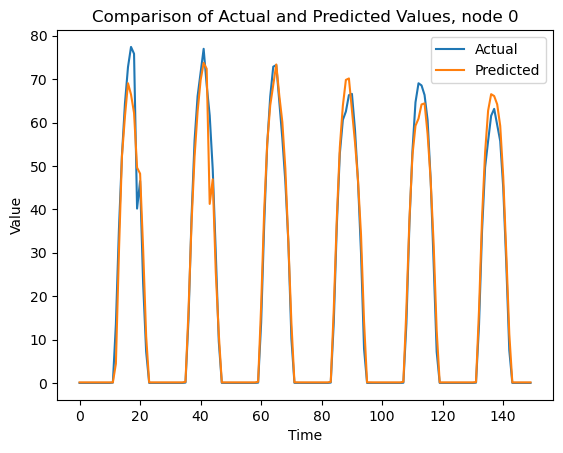

In [13]:
node_id = 0

plt.plot(Y[:150,node_id].cpu().detach().numpy(), label='Actual')
plt.plot(output[:150,node_id].cpu().detach().numpy(), label='Predicted')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Value')
plt.title(f'Comparison of Actual and Predicted Values, node {node_id}')
plt.show()

In [183]:
torch.save({'Y': Y, 'states': X}, 'KOP/DynGESN/states.pt')

# DMD

In [7]:
from DMD.dmd import KANN

In [8]:
Y, states = torch.load('KOP/DynGESN/states.pt').values()

In [9]:
states.shape

torch.Size([864, 200, 170])

In [186]:
node_id = 0
norms = []
for i in range(10):
    norms.append(torch.linalg.vector_norm(states[:-1,i+node_id,:]-states[1:,i+node_id,:], dim=(1)))

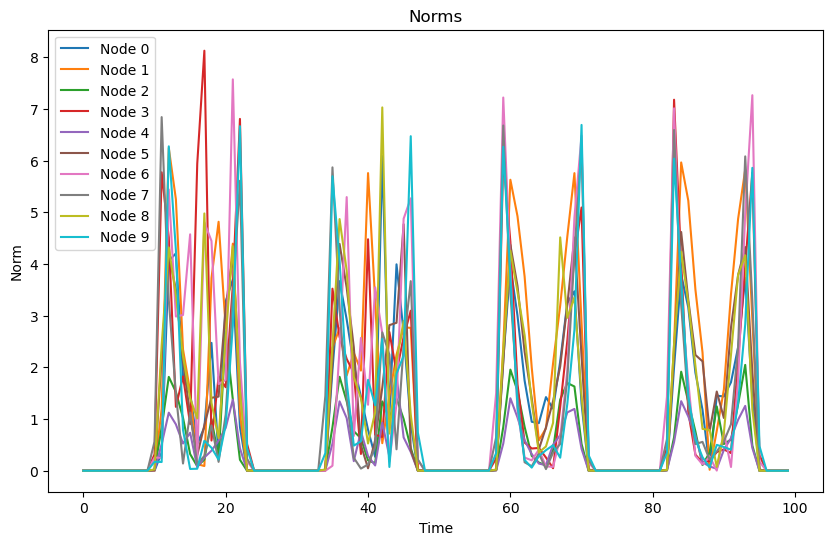

In [190]:
plt.figure(figsize=(10, 6))

for i, norm in enumerate(norms):
    plt.plot(norm.cpu().detach()[:100], label=f'Node {i+node_id}')

plt.xlabel('Time')
plt.ylabel('Norm')
plt.title('Norms')
plt.legend()
plt.show()

## Global Koopman analysis at a node level

In [20]:
states.shape

torch.Size([200, 864, 170])

### Try first with pure states: no non-linearities, no change of basis

In [17]:
dim_red = 50
method = None #'TruncatedSVD'

# compute local Koopman operator
states = rearrange(states, 't n f -> n t f')
kann_ = KANN(states.cpu(), k=dim_red, emb=method)

In [18]:
K0 = kann_.compute_KOP()

In [19]:
K0.shape

(170, 170)

Reconstruct trajectories

In [21]:
states = rearrange(states, 'n t f -> t n f')

In [22]:
n_states = []
s = states[0,:,:].cpu()

for t in range(states.shape[0]):
    n_states.append(s)
    s = s @ K0

n_states = torch.stack(n_states, dim=0)

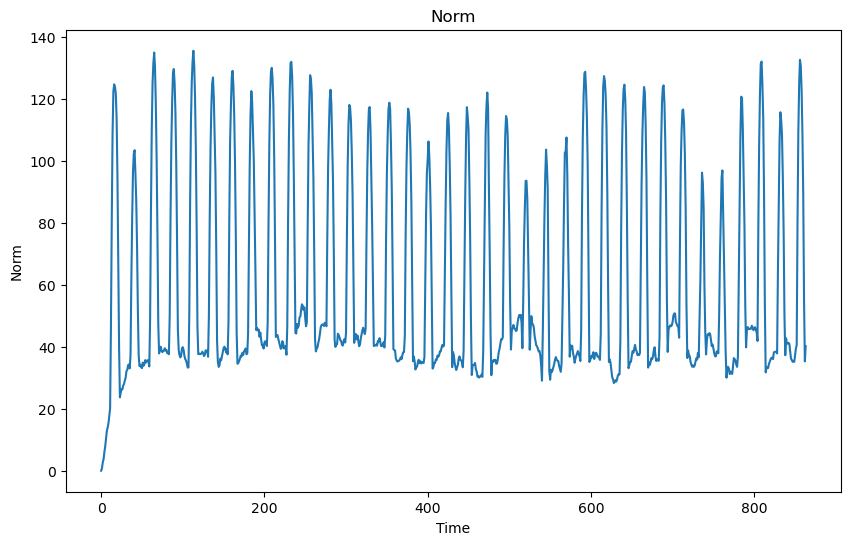

In [24]:
norm = torch.linalg.vector_norm(states[:,:,:].cpu()-n_states, dim=(1,2))

plt.figure(figsize=(10, 6))
plt.plot(norm.cpu().detach())
plt.xlabel('Time')
plt.ylabel('Norm')
plt.title('Norm')
plt.show()

In [25]:
output = loaded_model(n_states.to(device)).squeeze()

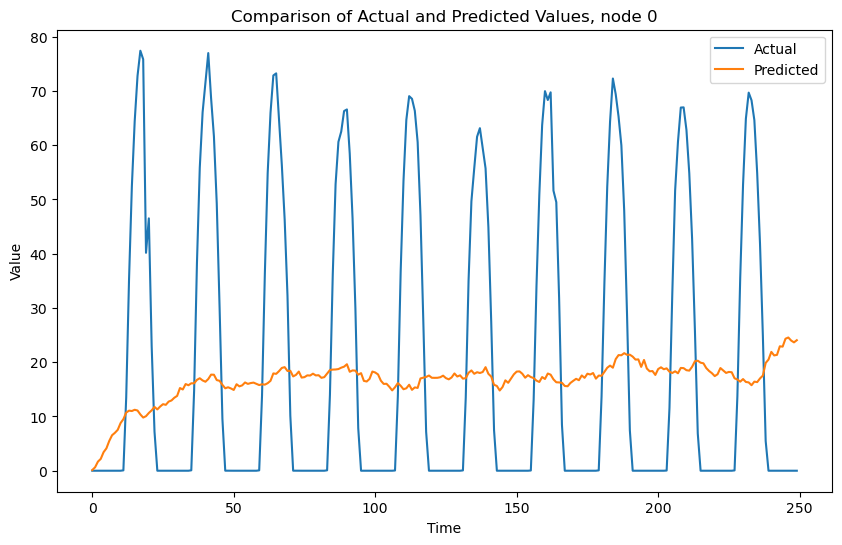

In [26]:
node_id = 0

plt.figure(figsize=(10, 6))
plt.plot(Y[:250,node_id].cpu().detach().numpy(), label='Actual')
plt.plot(output[:250,node_id].cpu().detach().numpy(), label='Predicted')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Value')
plt.title(f'Comparison of Actual and Predicted Values, node {node_id}')
plt.show()

Project status of a node on most important eigenvalues and check what patterns is reflected more on which eigenspace

In [27]:
E_global, V_global = np.linalg.eig(K0)

idx = E_global.argsort()[::-1]   
E_global = E_global[idx]
V_global = V_global[:,idx]

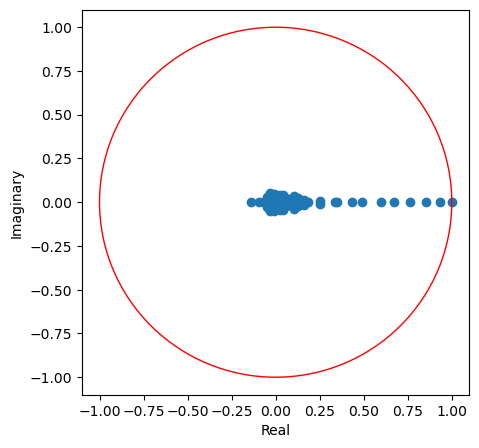

In [28]:
plt.figure(figsize=(5,5))
plt.scatter(E_global.real, E_global.imag)
circle = plt.Circle((0, 0), 1, color='r', fill=False)
plt.gca().add_patch(circle)
plt.ylabel('Imaginary') 
plt.xlabel('Real')
plt.show() 

In [204]:
states.shape

torch.Size([864, 200, 170])

In [29]:
proj_state0 = (states.cpu() @ V_global[:,0]).real # it's real anyway
proj_state1 = (states.cpu() @ V_global[:,1]).real # it's real anyway

In [30]:
proj_state0.shape

torch.Size([864, 200])

In [31]:
proj_states = torch.zeros_like(states.cpu())

for i in range(proj_state0.shape[0]):
    for j in range(proj_state0.shape[1]):
        proj_states[i,j,:] = proj_state0[i,j] * V_global[:,0] #+ proj_state1[i,j] * V_global[:,1]

C:\Users\mgphy\AppData\Local\Temp\ipykernel_26380\2370083793.py:5: UserWarning: Casting complex values to real discards the imaginary part (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\Copy.cpp:276.)
  proj_states[i,j,:] = proj_state0[i,j] * V_global[:,0] #+ proj_state1[i,j] * V_global[:,1]


In [32]:
proj_states.shape

torch.Size([864, 200, 170])

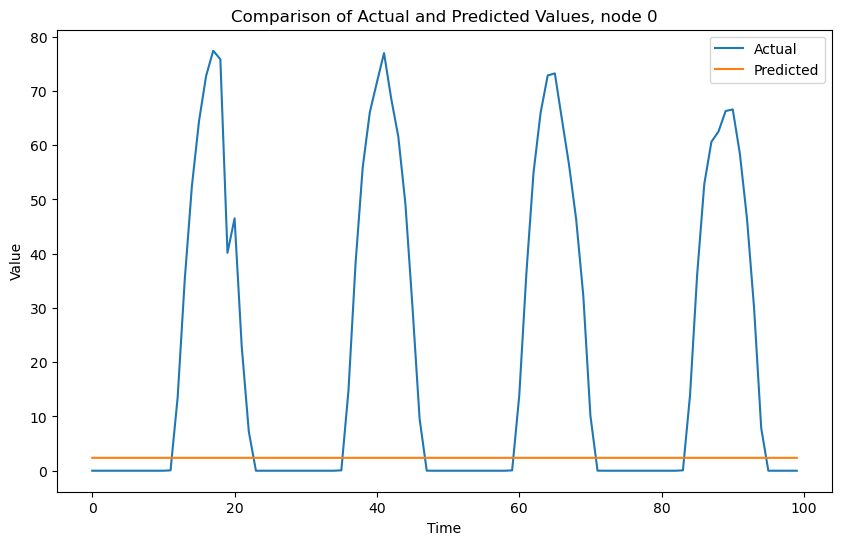

In [33]:
output = loaded_model(proj_states.to(device)).squeeze()

node_id = 0

plt.figure(figsize=(10, 6))
plt.plot(Y[:100,node_id].cpu().detach().numpy(), label='Actual')
plt.plot(output[:100,node_id].cpu().detach().numpy(), label='Predicted')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Value')
plt.title(f'Comparison of Actual and Predicted Values, node {node_id}')
plt.show()

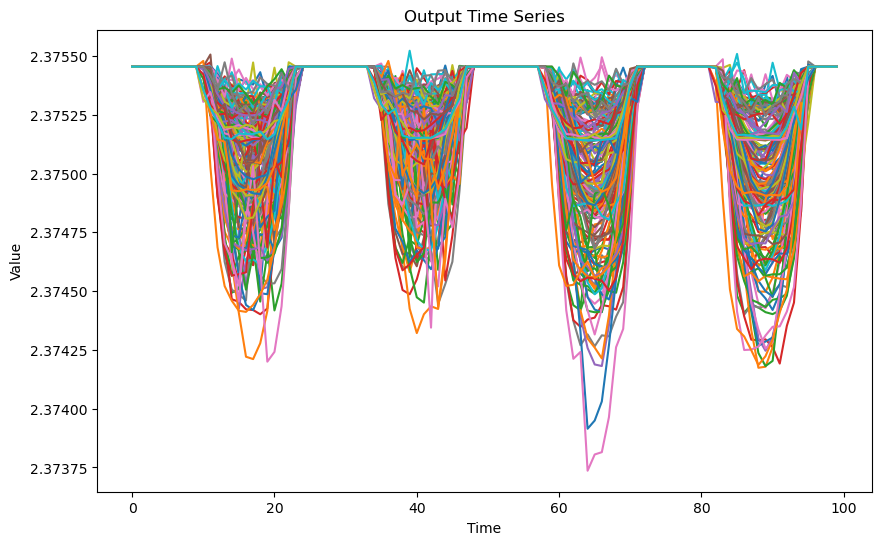

In [34]:
plt.figure(figsize=(10, 6))

for i in range(output.shape[1]):
    plt.plot(output[:100, i].cpu().detach().numpy())#, label=f'Time Series {i+1}')

plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Output Time Series')
# plt.legend()
plt.show()


There are very small patterns.

Let's check if they're there also in a random direction:

In [45]:
rand_dir = torch.rand_like(torch.from_numpy(V_global[:,0]))
rand_dir = rand_dir / torch.linalg.norm(rand_dir)

rand_proj_state = (states.cpu().type(torch.complex64) @ rand_dir).real

rand_proj_states = torch.zeros_like(states.cpu())

for i in range(rand_proj_state.shape[0]):
    for j in range(rand_proj_state.shape[1]):
        rand_proj_states[i,j,:] = rand_proj_state[i,j] * rand_dir[:]

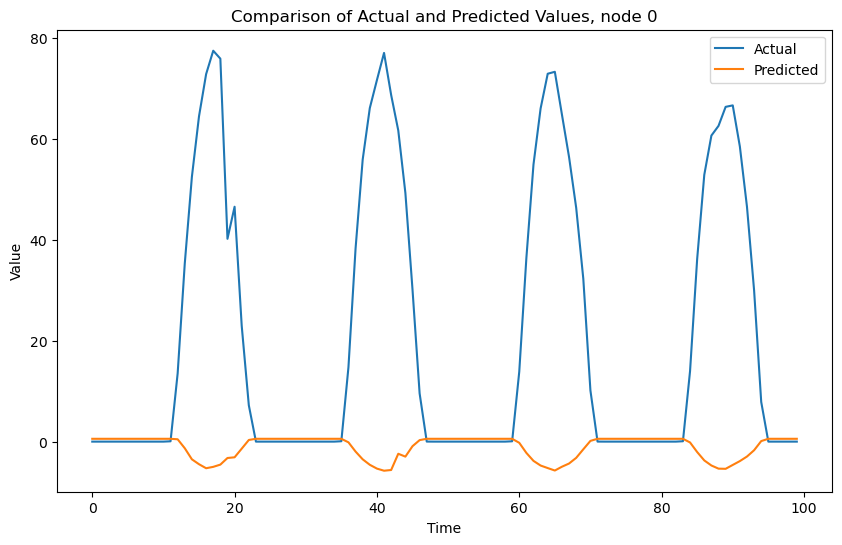

In [46]:
output = loaded_model(rand_proj_states.to(device)).squeeze()

node_id = 0

plt.figure(figsize=(10, 6))
plt.plot(Y[:100,node_id].cpu().detach().numpy(), label='Actual')
plt.plot(output[:100,node_id].cpu().detach().numpy(), label='Predicted')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Value')
plt.title(f'Comparison of Actual and Predicted Values, node {node_id}')
plt.show()

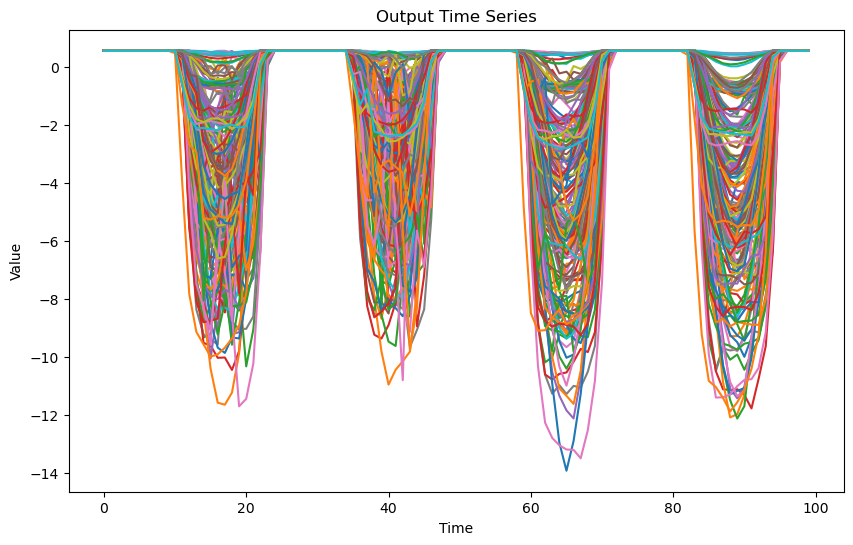

In [47]:
plt.figure(figsize=(10, 6))

for i in range(output.shape[1]):
    plt.plot(output[:100, i].cpu().detach().numpy())#, label=f'Time Series {i+1}')

plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Output Time Series')
# plt.legend()
plt.show()

Let's try the last eigenvector

In [49]:
proj_statef = (states.cpu() @ V_global[:,-1]).real

proj_states_f = torch.zeros_like(states.cpu())

for i in range(proj_statef.shape[0]):
    for j in range(proj_statef.shape[1]):
        proj_states_f[i,j,:] = proj_statef[i,j] * V_global[:,-1]

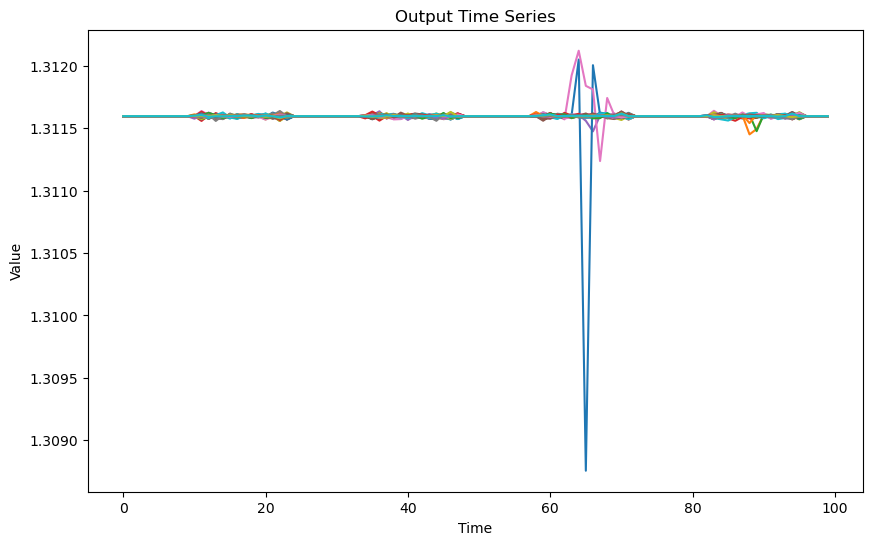

In [51]:
output = loaded_model(proj_states_f.to(device)).squeeze()

plt.figure(figsize=(10, 6))

for i in range(output.shape[1]):
    plt.plot(output[:100, i].cpu().detach().numpy())

plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Output Time Series')
plt.show()

The random direction works better

### Add change of basis

In [56]:
states.shape

torch.Size([200, 864, 170])

In [53]:
dim_red = 50
method = 'TruncatedSVD'

# compute local Koopman operator
states = rearrange(states, 't n f -> n t f')
kann_ = KANN(states.cpu(), k=dim_red, emb=method)

In [54]:
K1 = kann_.compute_KOP()

In [55]:
K1.shape

(50, 50)

In [62]:
s = torch.from_numpy(kann_.emb_engine.transform(states[:,0,:].cpu()))

n_states = []

for t in range(states.shape[1]):
    n_states.append(s)
    s = s @ K1

n_states = torch.stack(n_states, dim=0)

In [63]:
n_states.shape

torch.Size([864, 200, 50])

In [67]:
states = rearrange(states, 'n t f -> t n f')

In [68]:
# invert SVD
rec_states = torch.zeros_like(states.cpu())

for t in range(n_states.shape[0]):
    rec_states[t,:,:] = torch.from_numpy(kann_.emb_engine.inverse_transform(n_states[t,:,:].cpu()))


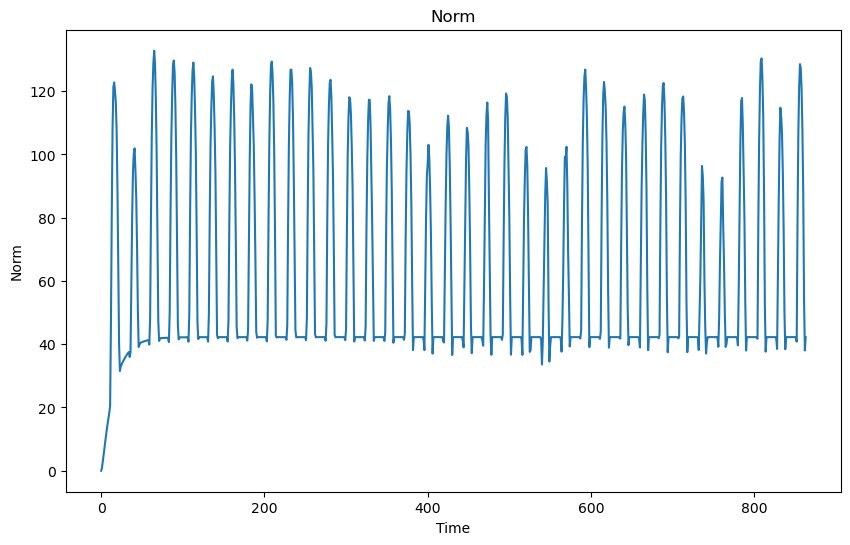

In [70]:
norm = torch.linalg.vector_norm(states[:,:,:].cpu()-rec_states, dim=(1,2))

plt.figure(figsize=(10, 6))
plt.plot(norm.cpu().detach())
plt.xlabel('Time')
plt.ylabel('Norm')
plt.title('Norm')
plt.show()

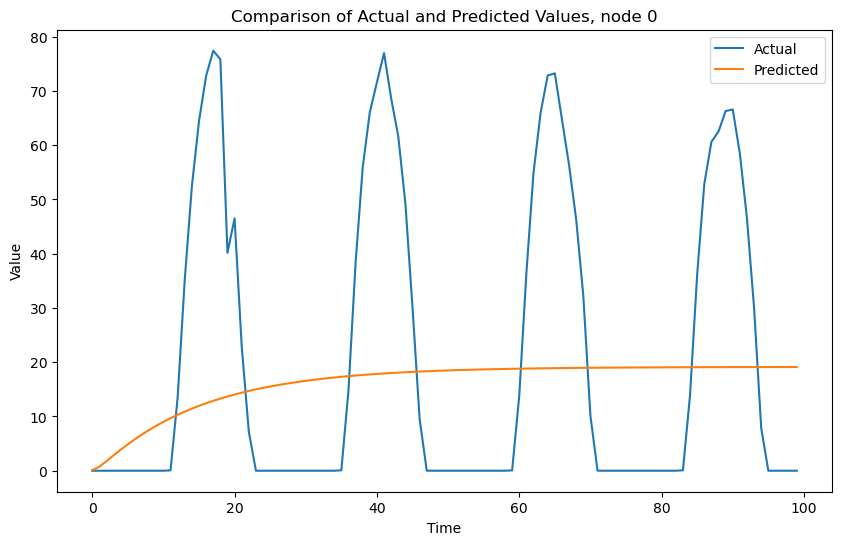

In [73]:
output = loaded_model(rec_states.to(device)).squeeze()

node_id = 0

plt.figure(figsize=(10, 6))
plt.plot(Y[:100,node_id].cpu().detach().numpy(), label='Actual')
plt.plot(output[:100,node_id].cpu().detach().numpy(), label='Predicted')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Value')
plt.title(f'Comparison of Actual and Predicted Values, node {node_id}')
plt.show()

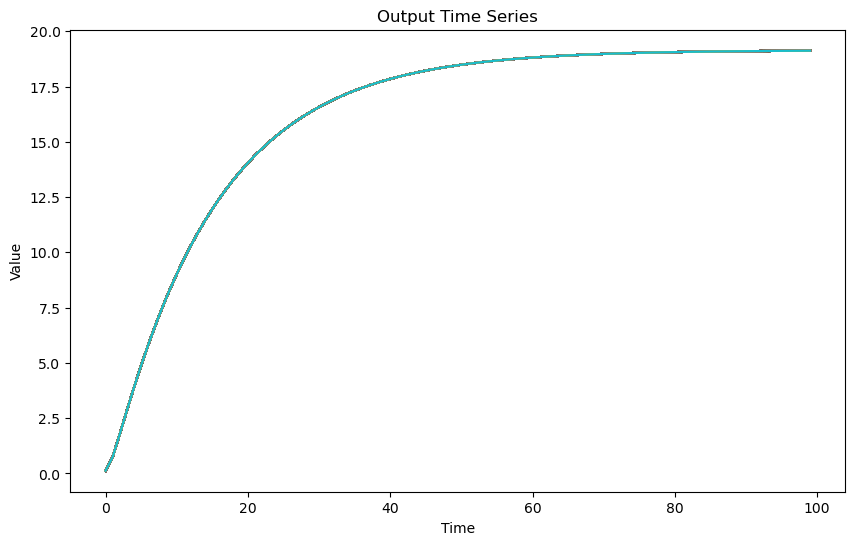

In [71]:
plt.figure(figsize=(10, 6))

for i in range(output.shape[1]):
    plt.plot(output[:100, i].cpu().detach().numpy())

plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Output Time Series')
plt.show()

### Add non-linearities

In [74]:
states.shape

torch.Size([864, 200, 170])

In [75]:
states2 = torch.cat([states,torch.pow(states, 2)], dim=2)

In [77]:
dim_red = 100
method = 'TruncatedSVD'

# compute local Koopman operator
states2 = rearrange(states2, 't n f -> n t f')
kann_ = KANN(states2.cpu(), k=dim_red, emb=method)

In [78]:
K2 = kann_.compute_KOP()

In [79]:
K2.shape

(100, 100)

In [94]:
states2.shape

torch.Size([864, 200, 340])

In [83]:
s = torch.from_numpy(kann_.emb_engine.transform(states2[:,0,:].cpu()))

n_states = []

for t in range(states2.shape[1]):
    n_states.append(s)
    s = s @ K2

n_states = torch.stack(n_states, dim=0)

In [84]:
n_states.shape

torch.Size([864, 200, 100])

In [86]:
states2 = rearrange(states2, 'n t f -> t n f')

In [90]:
# invert SVD
rec_states2 = torch.zeros_like(states2.cpu()[:,:,:170])

for t in range(n_states.shape[0]):
    rec_states2[t,:,:] = torch.from_numpy(kann_.emb_engine.inverse_transform(n_states[t,:,:].cpu()))[:,:170]

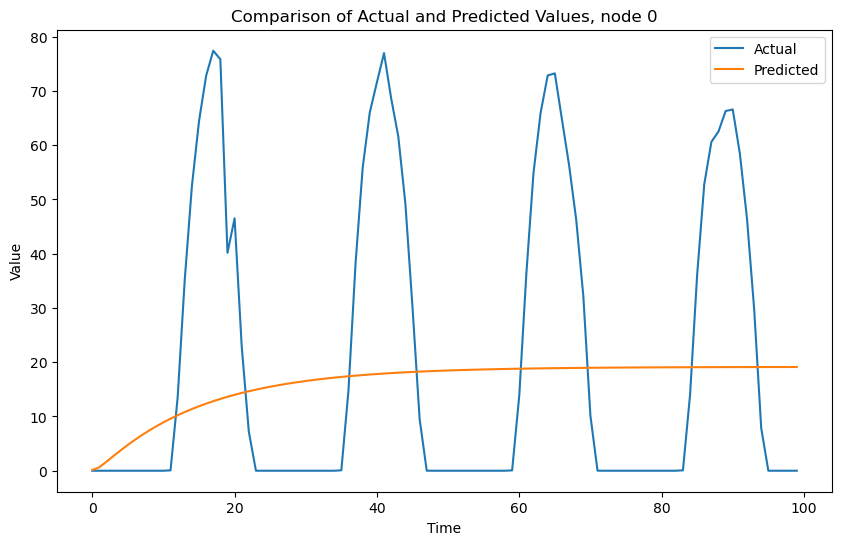

In [91]:
output = loaded_model(rec_states2.to(device)).squeeze()

node_id = 0

plt.figure(figsize=(10, 6))
plt.plot(Y[:100,node_id].cpu().detach().numpy(), label='Actual')
plt.plot(output[:100,node_id].cpu().detach().numpy(), label='Predicted')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Value')
plt.title(f'Comparison of Actual and Predicted Values, node {node_id}')
plt.show()

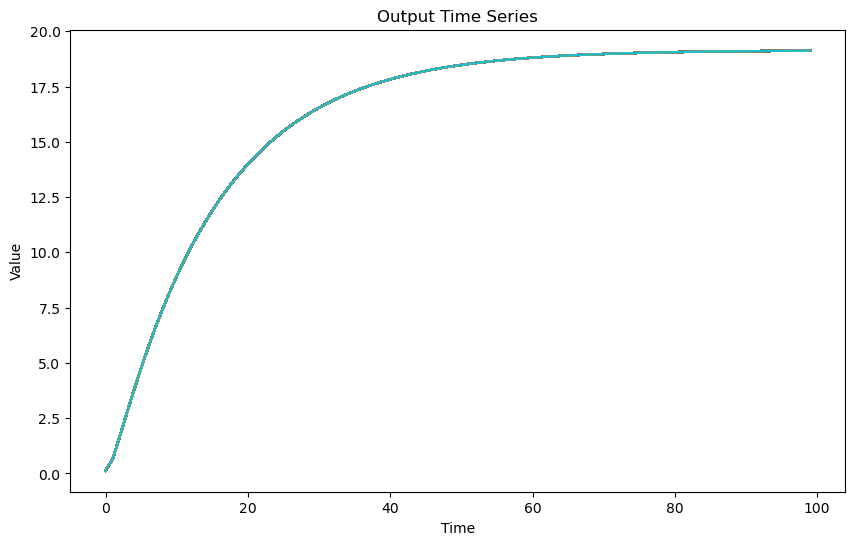

In [92]:
plt.figure(figsize=(10, 6))

for i in range(output.shape[1]):
    plt.plot(output[:100, i].cpu().detach().numpy())

plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Output Time Series')
plt.show()

It doesn't seem to work.

### No SVD + non-linearities

In [10]:
states.shape

torch.Size([864, 200, 170])

In [11]:
states3 = torch.cat([states,torch.pow(states, 2)], dim=2)
dim_red = 100
method = None #'TruncatedSVD'

# compute local Koopman operator
states3 = rearrange(states3, 't n f -> n t f')
kann_ = KANN(states3.cpu(), k=dim_red, emb=method)
K3 = kann_.compute_KOP()
K3.shape

(340, 340)

In [12]:
states3.shape

torch.Size([200, 864, 340])

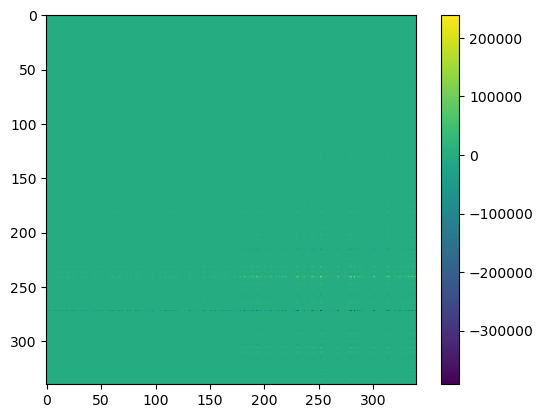

In [21]:
import matplotlib

plt.imshow(K3)#, norm=matplotlib.colors.LogNorm())
plt.colorbar()


In [22]:
n_states = []

s = states3[:,0,:].cpu()

for t in range(states3.shape[1]):
    n_states.append(s)
    s = s @ K3

n_states = torch.stack(n_states, dim=0)
n_states.shape
states3 = rearrange(states3, 'n t f -> t n f')

C:\Users\mgphy\AppData\Local\Temp\ipykernel_29016\2930553154.py:7: RuntimeWarning: overflow encountered in matmul
  s = s @ K3
C:\Users\mgphy\AppData\Local\Temp\ipykernel_29016\2930553154.py:7: RuntimeWarning: invalid value encountered in matmul
  s = s @ K3


In [23]:
states3.shape

torch.Size([864, 200, 340])

In [25]:
n_states.shape

torch.Size([864, 200, 340])

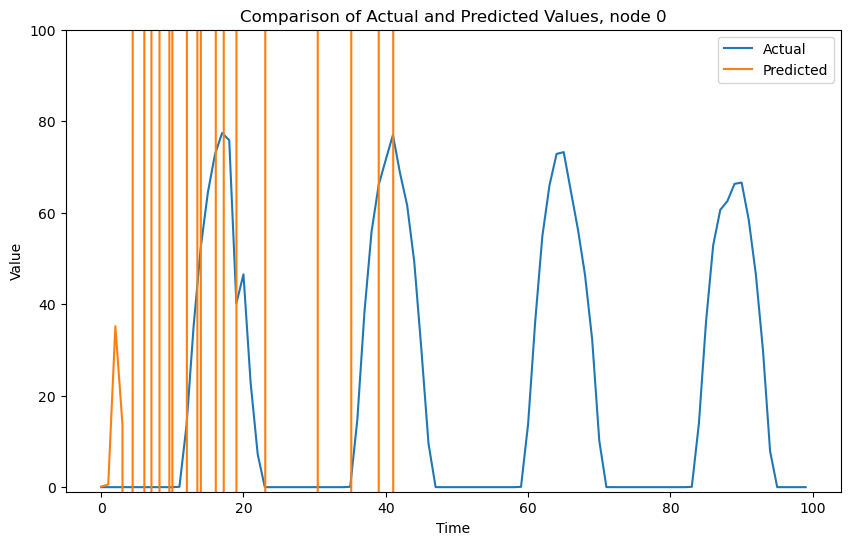

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

In [34]:
output = loaded_model(n_states[:,:,:170].to(device)).squeeze()

node_id = 0

plt.figure(figsize=(10, 6))
plt.plot(Y[:100,node_id].cpu().detach().numpy(), label='Actual')
plt.plot(output[:100,node_id].cpu().detach().numpy(), label='Predicted')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Value')
plt.ylim([-1, 100])
plt.title(f'Comparison of Actual and Predicted Values, node {node_id}')
plt.show()
plt.figure(figsize=(10, 6))

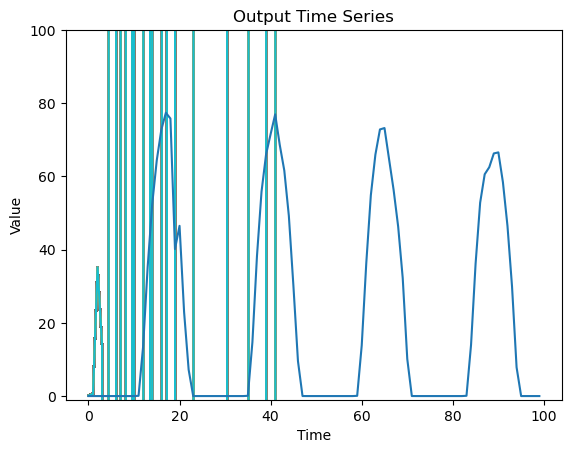

In [33]:
for i in range(output.shape[1]):
    plt.plot(output[:100, i].cpu().detach().numpy())
plt.plot(Y[:100,node_id].cpu().detach().numpy(), label='Actual')

plt.xlabel('Time')
plt.ylabel('Value')
plt.ylim([-1, 100])
plt.title('Output Time Series')
plt.show()

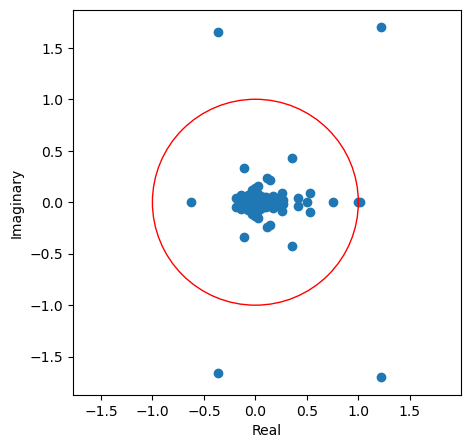

In [105]:
E3, V3 = np.linalg.eig(K3)

idx = E3.argsort()[::-1]   
E3 = E3[idx]
V3 = V3[:,idx]

plt.figure(figsize=(5,5))
plt.scatter(E3.real, E3.imag)
circle = plt.Circle((0, 0), 1, color='r', fill=False)
plt.gca().add_patch(circle)
plt.ylabel('Imaginary') 
plt.xlabel('Real')
plt.axis('equal')
plt.show()

In [123]:
E3[5]

(0.5329244+0.09212909j)

In [106]:
states3.shape

torch.Size([864, 200, 340])

In [114]:
proj_state0 = (states3.cpu() @ V3[:,0])
proj_state1 = (states3.cpu() @ V3[:,1])
proj_states = torch.zeros_like(states3.cpu())

for i in range(proj_state0.shape[0]):
    for j in range(proj_state0.shape[1]):
        proj_states[i,j,:] = proj_state0[i,j] * V3[:,0] + proj_state1[i,j] * V3[:,1]

In [115]:
output = loaded_model(proj_states[:,:,:170].to(device)).squeeze()

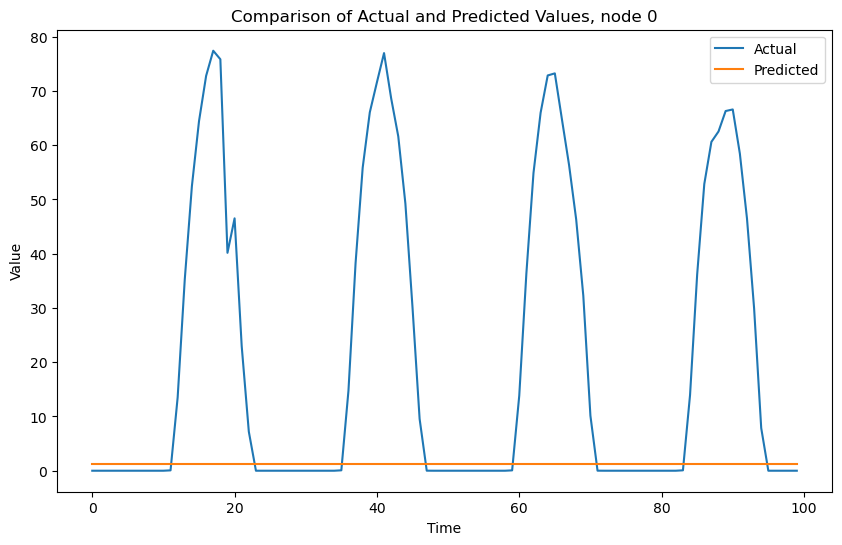

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

In [116]:
node_id = 0

plt.figure(figsize=(10, 6))
plt.plot(Y[:100,node_id].cpu().detach().numpy(), label='Actual')
plt.plot(output[:100,node_id].cpu().detach().numpy(), label='Predicted')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Value')
plt.title(f'Comparison of Actual and Predicted Values, node {node_id}')
plt.show()
plt.figure(figsize=(10, 6))

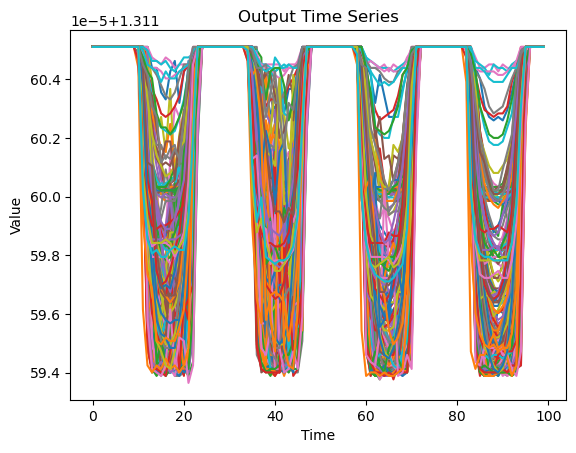

In [117]:
for i in range(output.shape[1]):
    plt.plot(output[:100, i].cpu().detach().numpy())
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Output Time Series')
plt.show()
